In [1]:
import pandas as pd
import re
import requests
from requests import get
from bs4 import BeautifulSoup
import time
import os
from env import github_token, github_username
import acquire as a
import prepare as p

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import json
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from time import strftime

pageCount = 15 
urlsList = []
base = "https://github.com/search?o=desc&p={}&q=shoes&s=stars&type=Repositories" #curly braces let you format


for x in range(pageCount)[0:]:
    urlsList.append(base.format(x))

urlsList

headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception("You need to follow the instructions marked TODO in this script before trying to use it")

def get_repo_links(github_token=github_token, github_username=github_username,
                                         topic='shoes', number_of_pages=5):
    '''
    Takes in a topic, your unique github API token, and your github username as
    strings and an interger for the number of pages to query
    Returns: list of repositories from GitHub in the form of
    '<username>/<repo_name>'
    '''
    # set URL without page number
    url = f'https://github.com/topics/{topic}?&s=stars&page='
    # set header for github auth
    headers = {"Authorization": f"token {github_token}",
               "User-Agent": github_username}
    # set empty list for total repos scraped
    list_of_repos = []
    # for each page in range of provided number
    for i in range(1, number_of_pages + 1):
        # obtain page data
        time.sleep(15)
        response = requests.get(url + str(i), headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        content = soup.find_all('h3')
        # set empty list to agg for each page
        page_list = []
        for repo in content:
            # confirms that h3 tag contains repo information
            if [re.search(r'(\S+)', x.text).group(1) for x in repo.find_all('a')] != []:
                # returns owner username and repo name
                user_name, repo_name = [re.search(r'(\S+)', x.text)\
                                         .group(1) for x in repo.find_all('a')]
                # add to page list for each repo on page
                page_list.extend([f'{user_name}/{repo_name}'])
        # add new page list into existing list for total repos
        list_of_repos.extend(page_list)
        print(f'Page {i} Completed')
    # saves returned list into .py file for calling in later functions
    with open("repos.py", "w") as repos:
        repos.write(f'REPOS = {list_of_repos}')
    return list_of_repos
    

repo_list = get_repo_links()

len(repo_list)

repo_list

In [2]:
#df = a.scrape_github_data()

In [3]:
df = pd.read_json('repos.json')

In [4]:
df.head()

,repo,language,readme_contents
0,justinmk/vim-sneak,Vim Script,sneak.vim 👟\n================\n\nJump to any l...
1,google-research-datasets/Objectron,Jupyter Notebook,"\n<div align=""center"">\n\n# Objectron Dataset\..."
2,shoes/shoes4,Ruby,# Shoes 4 [![Linux Build Status](https://secur...
3,shoes/shoes-deprecated,C,# THIS REPO IS NO LONGER ACTIVE!\n\n**Looking ...
4,filamentgroup/shoestring,JavaScript,:warning: This project is archived and the rep...


In [5]:
df['language'].dropna()

0            Vim Script
1      Jupyter Notebook
2                  Ruby
3                     C
4            JavaScript
             ...       
191                Dart
194          TypeScript
195          JavaScript
196                  C#
197                HTML
Name: language, Length: 185, dtype: object

In [6]:
df['language'].value_counts()

JavaScript          42
Ruby                41
Python              26
Dart                17
HTML                13
TypeScript           6
Jupyter Notebook     6
Java                 4
C#                   3
Swift                3
CSS                  3
C                    2
C++                  2
Kotlin               2
VimL                 2
Handlebars           1
Vue                  1
Go                   1
SCSS                 1
Emacs Lisp           1
Vim Script           1
Lua                  1
TeX                  1
Rust                 1
Shell                1
PHP                  1
Vim script           1
CoffeeScript         1
Name: language, dtype: int64

In [7]:
others = ['TypeScript', 'Jupyter Notebook', 'Java', 'C#', 'Swift', 'CSS', 'C', 'C++', 'Kotlin',
         'VimL', 'Handlebars', 'Vue', 'Go', 'SCSS', 'Emacs Lisp', 'Vim Script', 'Lua', 'TeX',
         'Rust', 'Shell', 'PHP', 'Vim script', 'CoffeeScript']

In [8]:
df = df.replace(to_replace=others, value="Other")

In [9]:
def prep_article_data(df, column, exclude_words=[]):

    df['clean'] = df[column].apply(p.basic_clean)\
                            .apply(p.tokenize)\
                            .apply(p.remove_stopwords,
                                  exclude_words=exclude_words)
    
    df['stemmed'] = df['clean'].apply(p.stem)
    
    df['lemmatized'] = df['clean'].apply(p.lemmatize)
    
    return df[['repo', column,'clean', 'stemmed', 'lemmatized']]

In [10]:
prep_article_data(df, 'readme_contents', exclude_words = ['slammer'])

,repo,readme_contents,clean,stemmed,lemmatized
0,justinmk/vim-sneak,sneak.vim 👟\n================\n\nJump to any l...,sneakvim jump location specified two character...,sneakvim jump locat specifi two charact sneak ...,sneakvim jump location specified two character...
1,google-research-datasets/Objectron,"\n<div align=""center"">\n\n# Objectron Dataset\...",div aligncenter objectron dataset objectron da...,div aligncent objectron dataset objectron data...,div aligncenter objectron dataset objectron da...
2,shoes/shoes4,# Shoes 4 [![Linux Build Status](https://secur...,shoes 4 linux build statushttpssecuretraviscio...,shoe 4 linux build statushttpssecuretraviscior...,shoe 4 linux build statushttpssecuretraviscior...
3,shoes/shoes-deprecated,# THIS REPO IS NO LONGER ACTIVE!\n\n**Looking ...,repo longer active looking continuing shoes 3 ...,repo longer activ look continu shoe 3 support ...,repo longer active looking continuing shoe 3 s...
4,filamentgroup/shoestring,:warning: This project is archived and the rep...,warning project archived repository longer mai...,warn project archiv repositori longer maintain...,warning project archived repository longer mai...
...,...,...,...,...,...
193,alexyoung/snake-shoes,h2. Snake in Shoes\n\nThis is a simple Snake g...,h2 snake shoes simple snake game written ruby ...,h2 snake shoe simpl snake game written rubi sh...,h2 snake shoe simple snake game written ruby s...
194,kaushiksheel/ShoesStore-Frontend-Typescript,# Shoe Store Ecommerce Application\n\n## Intro...,shoe store ecommerce application introduction ...,shoe store ecommerc applic introduct ecommerc ...,shoe store ecommerce application introduction ...
195,devyn/shoes-web,== Welcome to Radiant\n\nRadiant is a no-fluff...,welcome radiant radiant nofluff open source co...,welcom radiant radiant nofluff open sourc cont...,welcome radiant radiant nofluff open source co...
196,mjokic/adidas_carter,# adidas_carter\n\nAdidas carter helps you car...,adidas_carter adidas carter helps cart shoes a...,adidas_cart adida carter help cart shoe adida ...,adidas_carter adidas carter help cart shoe adi...


In [11]:
df = df.drop([29, 139])

In [12]:
df

,repo,language,readme_contents,clean,stemmed,lemmatized
0,justinmk/vim-sneak,Other,sneak.vim 👟\n================\n\nJump to any l...,sneakvim jump location specified two character...,sneakvim jump locat specifi two charact sneak ...,sneakvim jump location specified two character...
1,google-research-datasets/Objectron,Other,"\n<div align=""center"">\n\n# Objectron Dataset\...",div aligncenter objectron dataset objectron da...,div aligncent objectron dataset objectron data...,div aligncenter objectron dataset objectron da...
2,shoes/shoes4,Ruby,# Shoes 4 [![Linux Build Status](https://secur...,shoes 4 linux build statushttpssecuretraviscio...,shoe 4 linux build statushttpssecuretraviscior...,shoe 4 linux build statushttpssecuretraviscior...
3,shoes/shoes-deprecated,Other,# THIS REPO IS NO LONGER ACTIVE!\n\n**Looking ...,repo longer active looking continuing shoes 3 ...,repo longer activ look continu shoe 3 support ...,repo longer active looking continuing shoe 3 s...
4,filamentgroup/shoestring,JavaScript,:warning: This project is archived and the rep...,warning project archived repository longer mai...,warn project archiv repositori longer maintain...,warning project archived repository longer mai...
...,...,...,...,...,...,...
193,alexyoung/snake-shoes,None,h2. Snake in Shoes\n\nThis is a simple Snake g...,h2 snake shoes simple snake game written ruby ...,h2 snake shoe simpl snake game written rubi sh...,h2 snake shoe simple snake game written ruby s...
194,kaushiksheel/ShoesStore-Frontend-Typescript,Other,# Shoe Store Ecommerce Application\n\n## Intro...,shoe store ecommerce application introduction ...,shoe store ecommerc applic introduct ecommerc ...,shoe store ecommerce application introduction ...
195,devyn/shoes-web,JavaScript,== Welcome to Radiant\n\nRadiant is a no-fluff...,welcome radiant radiant nofluff open source co...,welcom radiant radiant nofluff open sourc cont...,welcome radiant radiant nofluff open source co...
196,mjokic/adidas_carter,Other,# adidas_carter\n\nAdidas carter helps you car...,adidas_carter adidas carter helps cart shoes a...,adidas_cart adida carter help cart shoe adida ...,adidas_carter adidas carter help cart shoe adi...


In [29]:
other_words = p.clean_text(' '.join(df[df['language'] == 'Other']['readme_contents']))
javascript_words = p.clean_text(' '.join(df[df['language'] == 'JavaScript']['readme_contents']))
html_words = p.clean_text(' '.join(df[df['language'] == 'HTML']['readme_contents']))
dart_words = p.clean_text(' '.join(df[df['language'] == 'Dart']['readme_contents']))
ruby_words = p.clean_text(' '.join(df[df['language'] == 'Ruby']['readme_contents']))
python_words = p.clean_text(' '.join(df[df['language'] == 'Python']['readme_contents']))
all_words = p.clean_text(' '.join(df['readme_contents']))

In [30]:
other_counts = pd.Series(other_words).value_counts()
javascript_counts = pd.Series(javascript_words).value_counts()
html_counts = pd.Series(html_words).value_counts()
dart_counts = pd.Series(dart_words).value_counts()
ruby_counts = pd.Series(ruby_words).value_counts()
python_counts = pd.Series(python_words).value_counts()
all_counts = pd.Series(all_words).value_counts()

In [31]:
word_freq = pd.concat([other_counts, javascript_counts, html_counts, dart_counts, 
                       ruby_counts, python_counts, all_counts], axis=1)
word_freq.head()

,0,1,2,3,4,5,6
run,55.0,45.0,8.0,9.0,53.0,26.0,201
img,38.0,32.0,7.0,15.0,2.0,7.0,101
project,37.0,66.0,35.0,22.0,27.0,15.0,208
file,36.0,42.0,65.0,NaN,53.0,28.0,237
use,36.0,54.0,19.0,3.0,49.0,39.0,203


In [32]:
word_freq.columns = ['other', 'javascript', 'html', 'dart', 'ruby', 'python', 'all']
word_freq.fillna(0, inplace=True)
word_freq.head()

,other,javascript,html,dart,ruby,python,all
run,55.0,45.0,8.0,9.0,53.0,26.0,201
img,38.0,32.0,7.0,15.0,2.0,7.0,101
project,37.0,66.0,35.0,22.0,27.0,15.0,208
file,36.0,42.0,65.0,0.0,53.0,28.0,237
use,36.0,54.0,19.0,3.0,49.0,39.0,203


In [33]:
word_freq.dtypes

other         float64
javascript    float64
html          float64
dart          float64
ruby          float64
python        float64
all             int64
dtype: object

In [34]:
word_freq = word_freq.astype('int')
word_freq.head()

,other,javascript,html,dart,ruby,python,all
run,55,45,8,9,53,26,201
img,38,32,7,15,2,7,101
project,37,66,35,22,27,15,208
file,36,42,65,0,53,28,237
use,36,54,19,3,49,39,203


In [35]:
word_freq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9052 entries, run to pandasdataframedata
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   other       9052 non-null   int64
 1   javascript  9052 non-null   int64
 2   html        9052 non-null   int64
 3   dart        9052 non-null   int64
 4   ruby        9052 non-null   int64
 5   python      9052 non-null   int64
 6   all         9052 non-null   int64
dtypes: int64(7)
memory usage: 565.8+ KB


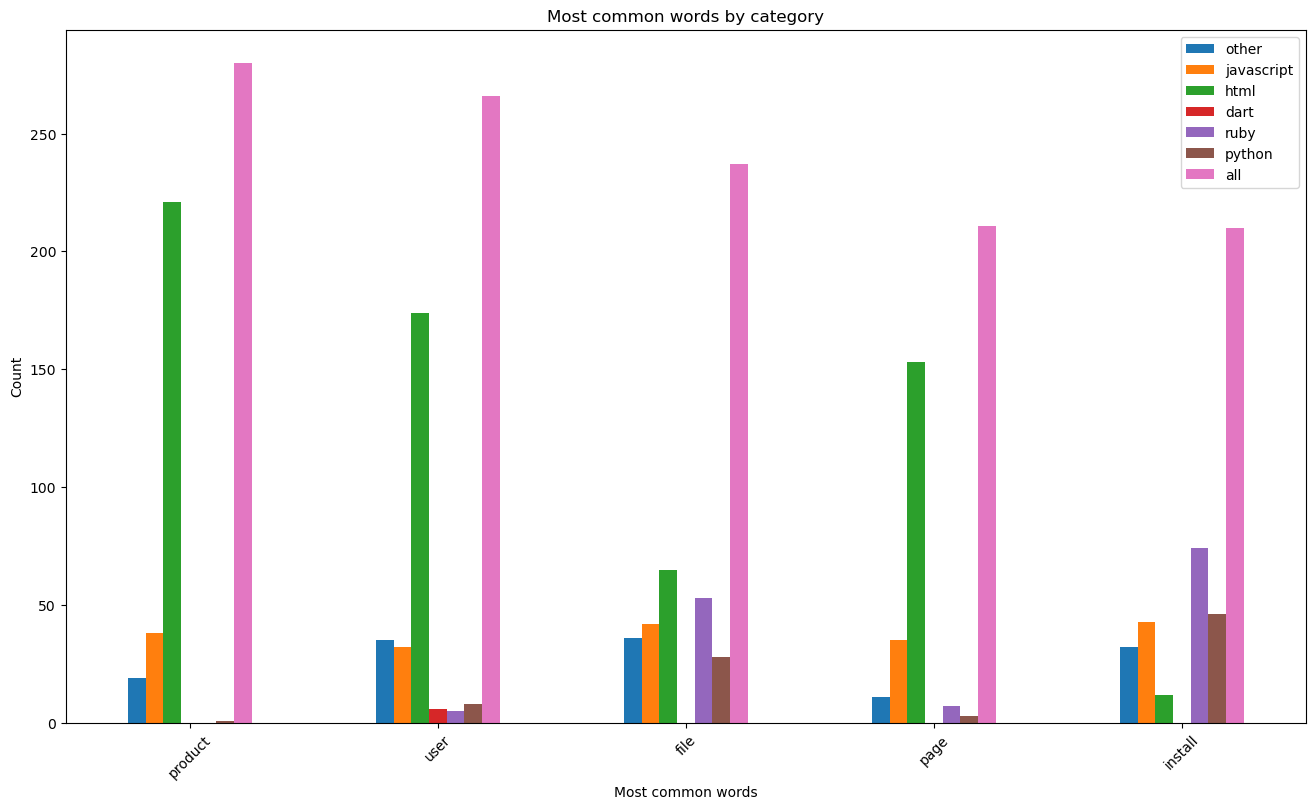

In [36]:
word_freq.sort_values('all', ascending=False).head(5).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

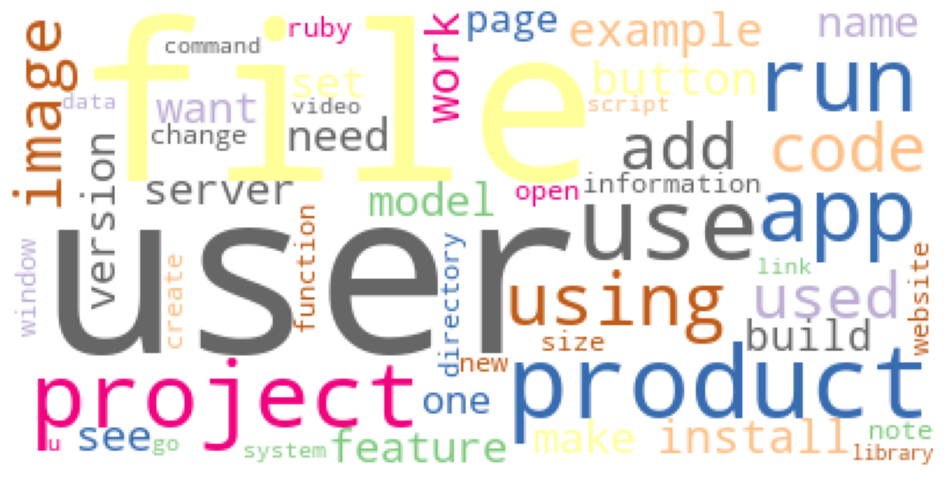

In [37]:
all_cloud = WordCloud(max_words = 50, background_color='white', colormap = 'Accent').generate(' '.join(all_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud)
plt.axis('off')
plt.show()

In [38]:
shoe_mask2 = np.array(Image.open("shoe_mask2.png"))
shoe_mask2


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [39]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val


In [40]:
transformed_shoe_mask = np.ndarray((shoe_mask2.shape[0],shoe_mask2.shape[1]), np.int32)

for i in range(len(shoe_mask2)):
    transformed_shoe_mask[i] = list(map(transform_format, shoe_mask2[i]))

In [41]:
transformed_shoe_mask


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

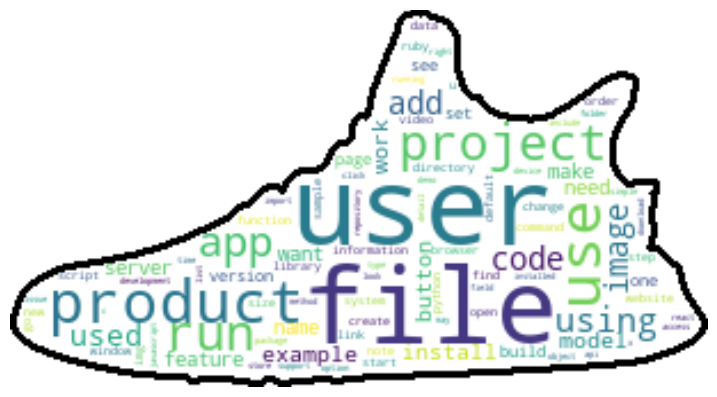

In [42]:
wc = WordCloud(background_color="white", max_words=150, mask=transformed_shoe_mask, contour_width=2, contour_color='black')

# Generate a wordcloud
wc.generate(' '.join(all_words))

# store to file
wc.to_file("shoe_mask.png")

# show
plt.figure(figsize=[9,6])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
bee_mask = np.array(Image.open("bee_mask.png"))
bee_mask


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [45]:
transformed_bee_mask = np.ndarray((bee_mask.shape[0],bee_mask.shape[1]), np.int32)

for i in range(len(bee_mask)):
    transformed_bee_mask[i] = list(map(transform_format, bee_mask[i]))

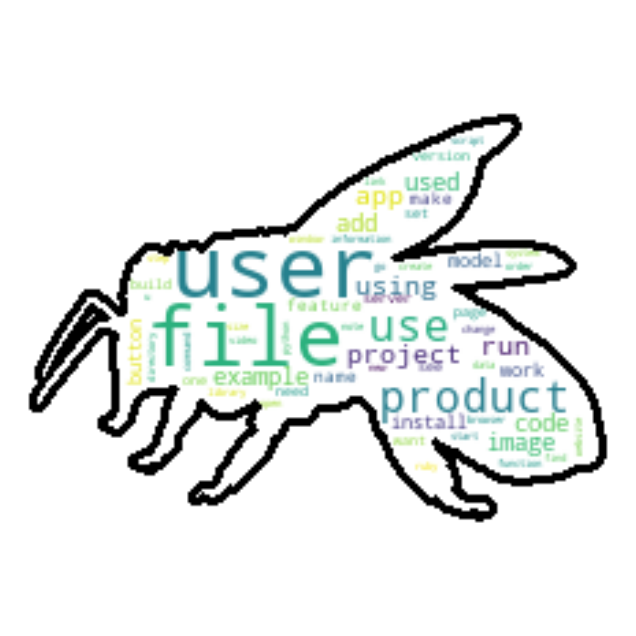

In [47]:
wc = WordCloud(background_color="white", max_words=150, mask=transformed_bee_mask, contour_width=2, contour_color='black')

# Generate a wordcloud
wc.generate(' '.join(all_words))

# store to file
wc.to_file("bee_mask.png")

# show
plt.figure(figsize=[12,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()